In [1]:
import numpy as np
import kernelforge
from kernelforge import inverse_distance_upper, kernel_symm, kernel_asymm, inverse_distance_upper_and_jacobian
import matplotlib.pyplot as plt
import gc
from time import time
from scipy.stats import pearsonr
from kernelforge._kernels import rbf_hessian_full_tiled_gemm
import sys
from kernelforge import _kernels
from time import time
from kernelforge._kernels import solve_cholesky

In [2]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
X = np.asarray([inverse_distance_upper(r) for r in train["R"]])
y = train["E"].flatten()
offset = y.mean()
y -= offset

In [3]:
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
Xp = np.asarray([inverse_distance_upper(r) for r in test["R"][:999]])
Yt = test["E"][:999].flatten() - offset
Xp.shape

(999, 36)

In [4]:
dX = np.asarray([inverse_distance_upper_and_jacobian(r)[1] for r in train["R"]])
dX.shape

(1000, 36, 27)

In [5]:
dXp = np.asarray([inverse_distance_upper_and_jacobian(r)[1] for r in test["R"][:999]])
dXp.shape

(999, 36, 27)

In [6]:
sigma = 1.0
alpha = -1/(2*sigma**2)
diago = 1e-6
print(alpha, sigma)

-0.5 1.0


In [7]:
K = kernel_symm(X, alpha)
L = np.tril(K)
K = L + L.T - np.diag(np.diag(L))
np.fill_diagonal(K, K.diagonal() + diago)

In [8]:
reg = np.linalg.solve(K, y)
reg[:10]

array([-129734.35596543,  -68820.1986675 ,  -60929.16201134,
          9805.58594385,  -89020.5422512 ,  -13861.50074678,
         -1031.34816097,    2277.24061605,   12258.93126713,
         37691.15244881])

In [9]:
# Change layout
Kp = kernel_asymm(Xp, X, alpha)
Yp = (Kp @ reg).flatten()

RMSE = 1.0387116614350842
PearsonRResult(statistic=np.float64(0.9756610190843165), pvalue=np.float64(0.0))


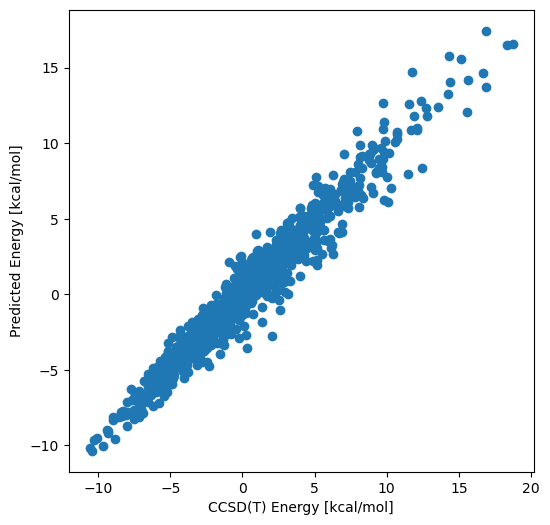

In [10]:
rmse = np.sqrt(np.mean(np.square(Yt - Yp)))
res = pearsonr(Yt, Yp)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.scatter(Yt, Yp)

In [11]:
t_start = time()
dK = _kernels.gaussian_jacobian_batch(Xp, dXp, X, sigma)
t_end = time()
print(t_end - t_start)
Fp = dK @ reg
Fp.reshape(-1,3)

0.165238618850708


array([[-27.59895498,   4.49002047, -16.60156596],
       [-20.56901534,  -3.8170813 ,  23.00712686],
       [  5.71377179,  15.19970054,  14.53243113],
       ...,
       [-12.56702898,   8.40567976,   5.6053111 ],
       [ 24.12541247,  -1.52158993,  -0.32145231],
       [-17.91244469,   1.84340812, -30.12658421]], shape=(8991, 3))

RMSE = 5.33 kcal/mol/Å
PearsonRResult(statistic=np.float64(0.9809921371195887), pvalue=np.float64(0.0))


Text(0, 0.5, 'Predicted Force [kcal/mol/Å]')

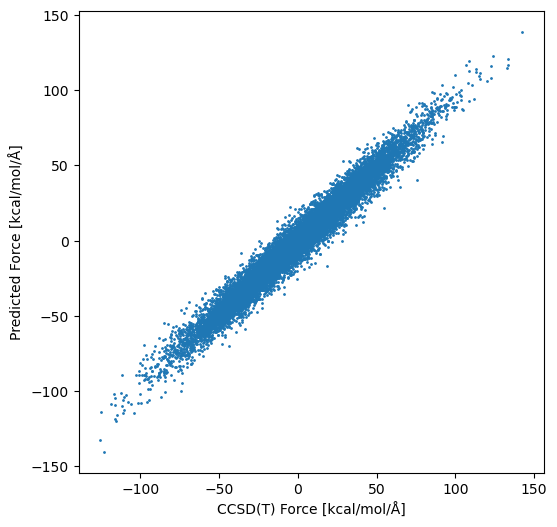

In [27]:
fig = plt.figure(figsize=(6,6))
plt.scatter(
    test["F"].flatten()[:999*9*3],#[:1000],
    -Fp.flatten(),
    s=1
)
res = pearsonr(test["F"].flatten()[:999*9*3], -Fp.flatten())
rmse = np.sqrt(np.mean(np.square(test["F"].flatten()[:999*9*3] + Fp.flatten())))

print(f"RMSE = {rmse:.2f} kcal/mol/Å")
print(res)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")

In [13]:
t_start = time()
H = rbf_hessian_full_tiled_gemm(X, dX, X,dX, sigma)
t_end = time()
print(t_end - t_start)
# H

2.6483702659606934


In [14]:
sub = H[:1000, :1000].copy()
np.max(sub - sub.T)

np.float64(2.220446049250313e-16)

In [15]:
yf = train["F"].flatten()
yf.shape

(27000,)

In [16]:
#np.fill_diagonal(H, H.diagonal() + diago)
for i in range(27000):
    H[i,i] += 1e-10
t_start = time()
reg = solve_cholesky(H, yf)
t_end = time()
print(t_end - t_start)
reg[:10]

48.813700914382935


array([-2779073.44616038,  5712580.867442  ,  2399629.65415436,
         865406.64771143,   881967.9352621 ,  -773365.66826331,
       -2250173.13847762,  7958414.6263821 ,  8277663.43449514,
        1915470.57302289])

In [17]:
print(sys.getrefcount(H))   # includes the temporary ref from getrefcount
for obj in gc.get_referrers(H):
    print(type(obj))
del H

2
<class 'dict'>


In [18]:
t_start = time()
Hp = rbf_hessian_full_tiled_gemm(Xp, dXp, X,dX, sigma)
t_end = time()
print(t_end - t_start)
# Hp

2.4330244064331055


In [19]:
Fpp = Hp @ reg
Fpp

array([32.03874668, -0.84056978, 25.96815817, ..., 20.37115452,
       -0.43253309, 29.91474841], shape=(26973,))

In [20]:
print(sys.getrefcount(Hp))   # includes the temporary ref from getrefcount
for obj in gc.get_referrers(Hp):
    print(type(obj))
del Hp

2
<class 'dict'>


RMSE = 1.19 kcal/mol/Å
PearsonRResult(statistic=np.float64(0.9990579771734678), pvalue=np.float64(0.0))


Text(0, 0.5, 'Predicted Force [kcal/mol/Å]')

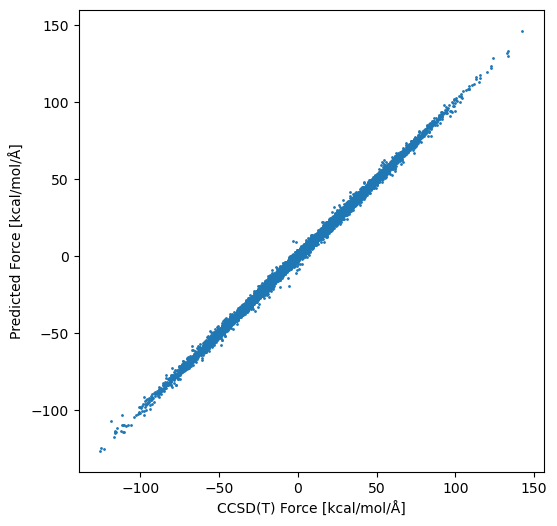

In [32]:
fig = plt.figure(figsize=(6,6))
plt.scatter(
    test["F"][:999].flatten(),#[:1000],
    Fpp.flatten(),
    s=1
)
res = pearsonr(test["F"][:999].flatten(), Fpp.flatten())
rmse = np.sqrt(np.mean(np.square(test["F"][:999].flatten() - Fpp.flatten())))
print(f"RMSE = {rmse:.2f} kcal/mol/Å")
print(res)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")